#  Introduction

To understand how Blockchain works we must first discuss how distribtued systems work.

The goal of this notebook is to explain the building blocks for any distirbuted system, a particularly a peer-to-peer system. P2P environment is a network where peers are connected, exchange information and run applications on top of it.

The goals are as follows:
- We will build a system block by block.
- Distributed systems are hard; there are many random errors: race conditions, nasty bugs, deadlocks.
- We will simplify the world to get to juiciest parts without leaving out the essentials.  


We will simulate the p2p environment locally to get the idea of how such system work and get the design decision that developers make when designing such systems.

To show different tradeoffs and why developers and researcher choose specific designs, we need a way to simulate such environment. Here we will simulate the network and message exchange via a  discrete event simulator: [SimPy](simpy.readthedocs.io/en/latest/).

For the simplicity of use, you can use wrapper for Simpwe implement a P2P network simulation: `p2psimpy`. 


# Simulation of P2P environments

We start the notebook by introducitng the backbones for a simulation: `BaseSimulation`.
This class represents the network of peers with their physical representations in the world, such as physical `location`, [`bandwidth`](https://en.wikipedia.org/wiki/Bandwidth_(computing)). 

These properties both define and restrict the capabalities of how fast you can transfer message and how the message passes travles through the network (which peers see the message, which channels are used).


`BaseSimulation` consists of 3 main parameters: 
 - *Locations*
 - *Network Topology* 
 - *Services and Message Processors* 

We will explain them one by one. 



### Locations 

The simulator simulates connections delays (`latency`) between the nodes in the physical space (`location`).
This is a very rough representation of reality, but is sufficient for us.  



Locations are defined as a `Config` class. Variables can be constant, or probabilistic (with a probability distribution using scipy).
This class can be used as generators of parameters, saved and loaded as [YAML](https://en.wikipedia.org/wiki/YAML) file.

Location configuration should contain at least two fields: `locations` and `latencies`. 
- `locations` is an array or a tuple with names of locations.
- `latencies` is a dictionary (matrix) with latencies of pairwise connections.

Depending on the experiments, latencies can be constant, but a more realistic model is a probabilistic distribution.
Such distribution is represented with `Dist` class. 

`Dist` class is a wrap-around [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html), which has a rich collection of distributions. Use the [link](https://docs.scipy.org/doc/scipy/reference/stats.html) as a reference documentation when choosing a distirbution function.   

Finally,  `Config.get()` samples all the parameters from distributions and returns them as a dictionary.  

Let's try it out:

In [ ]:
Explain why distribution makes sense - jitter 
# Latencies aren't const



In [10]:
from p2psimpy.config import *


class ConstLocations(Config):
    '''A configuration with 2 locations: LocA and LocB with constant latencies.'''
    locations = ['LocA', 'LocB']
    latencies = {
        'LocA': {'LocB': 10, 'LocA': 2},
        'LocB': {'LocB': 1}
    }    

class DistLocations(Config):
    '''A configuration with 2 locations: LocA and LocB with variable latencies defined with a statistical function.'''
    locations = ['LocA', 'LocB']
    latencies = {
        'LocB': {'LocB': Dist('gamma', (1, 1, 1))},
        'LocA': {'LocB': Dist('norm', (12, 2)), 'LocA': Dist('norm', (2, 0.5))},
    }    
    

In [8]:
ConstLocations.get()

{'latencies': {'LocA': {'LocB': 10, 'LocA': 2}, 'LocB': {'LocB': 1}},
 'locations': ['LocA', 'LocB']}

In [4]:
DistLocations.get()

{'latencies': {'LocB': {'LocB': 1.6393804009100026},
  'LocA': {'LocB': 10.857344785903441, 'LocA': 1.9516169004021526}},
 'locations': ['LocA', 'LocB']}

Every time you call `Config.get()` it will return new sample

In [5]:
DistLocations.get()

{'latencies': {'LocB': {'LocB': 1.2078745454149307},
  'LocA': {'LocB': 14.274658978491406, 'LocA': 2.2083191059878438}},
 'locations': ['LocA', 'LocB']}

To visualize it we can represent latencies sample as pandas dataframe. It provides a readable table:

In [12]:
import pandas as pd 

lat_sample = pd.DataFrame(DistLocations.get()['latencies'])
lat_sample

,LocB,LocA
LocB,4.709333,11.894776
LocA,NaN,1.871933


*Notice that table has **NaN** values. They will not be automatically filled with symmetric value if not specified.*

We can transform the table to fill them up symmetrically. 

In [13]:
lat_sample[pd.isnull(lat_sample)] = lat_sample.T[pd.isnull(lat_sample)]
lat_sample

,LocB,LocA
LocB,4.709333,11.894776
LocA,11.894776,1.871933



### Visualizing the data


 1. Prepare data: 
  - Trasfer to dataframe
  - Fill null values with symmetic 
  - Traform into list of tuples: 'from', 'to', 'value' 
  
 2. Get 100 samples from the configuration with latencies
 
 3. Visualize in a grid of histograms



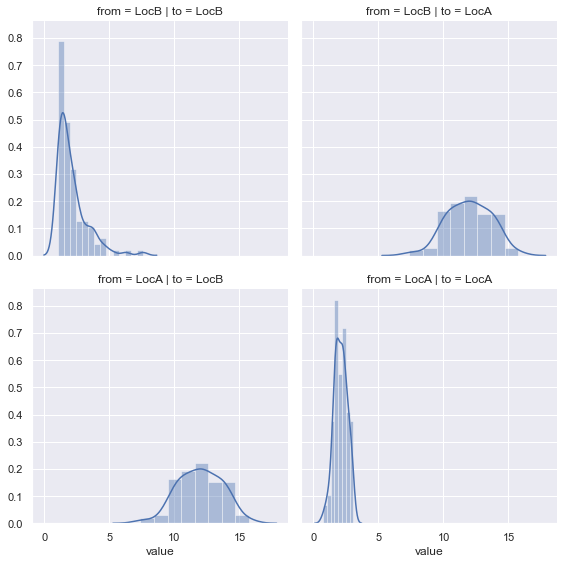

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# 1. Data prepare
def prepare(x):
    x = pd.DataFrame(x)
    x[pd.isnull(x)] = x.T[pd.isnull(x)]
    return x.stack().reset_index()\
                    .rename(columns={'level_0':'from', 'level_1':'to', 0: 'value'})
                    
# 2. Get 100 samples
df = pd.concat(prepare(DistLocations.get()['latencies']) for _ in range(100))

# 3. Visualize in a grid of histograms
g = sns.FacetGrid(df, col='to', row='from', height=4, aspect=1)
g = g.map(sns.distplot, 'value')


The visulations shows latency matrix for our two locations. 

----
## Peers and Topologies 

Usually when desinging own system the architechtor should think about the network topology: *How are peer connected to each other*. 


Simulation can work in two modes: 

1. **NetworkX**. You know what topology you want to simulate, pass a network topology to the simulation.

2. **Emergent**. Peers connect to each other without a pre-defined topology. A ceratin topology emerges through local rules, for example, peers connect with each other through the bootstrap peers and exchange data with each other. Typically, unstructured topologies of a peer-to-peer network follow into this category. You can read more [here](https://en.wikipedia.org/wiki/Bootstrapping_node), or  read how [Bitcoin network](https://en.bitcoin.it/wiki/Network) is formed.  


### Networkx topology

Let's first see how we can form a network topology.


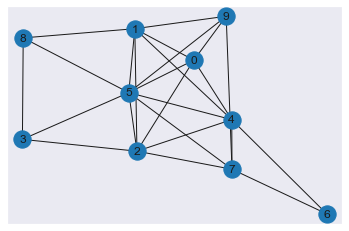

In [16]:
import networkx as nx

peer_num = 10

# Generate a random network network topology 
G = nx.erdos_renyi_graph(10, 0.5)

# Assign a peer type to the peers with a type. Type if later used to tell which services to run.
nx.set_node_attributes(G, {k: 'basic' for k in G.nodes()}, 'type')

sns.set(style='dark')
nx.draw_networkx(G)


NetworkX is a library with a rich semantics to work with graphs. You can read more [here](https://networkx.github.io/documentation/stable/reference/generators.html).  

You can choose any graph, generate them and put `type` as node attributes. `type` is a name for the peer type. We explain later how it will be used in a simulation.  



### Emergent topology

What if topology is not known?

In this case we can model the peer discovery mechanism through *bootstrapping* peers. General bootstrap process is following: 
1. Bootstrap nodes are first created and introduced to the network. The goal of bootstrap nodes is to maintain list of peers and connect them with each other upon request. Bootstrap nodes are usually known in advance, for example, hardcoded in the supplied code. 
2. The bootstrap procedure is as follows: a) new peer joins the network, b) peer sends a `Hello` message to one of bootstrap nodes, c) a bootstrap node responds to the peer with a random sample of known online peers. 
3. The peer connect with other peers from the given sample list.


To run default bootstrap you should pass as a parameter `topology` a dictionary with type `peer_id` -> {`type`: type_name}
This is all abstracted in simulation, but you can specify your own bootstrap logic later. 


### Explain more

Discovery 

-------
## Peer types and services

Finally, our simulation needs messages and service to process these messages. In `p2psimpy` we model it through Manager Classes and `PeerType`.

Below we give an example of a simple map with one type of the peer: `basic`: 

- Peer is described with a `PeerType(PeerConfig, services)`. 
    - `PeerConfig` describes a physical capacities of the node: bandwidth for the messages that go through (upload and download) and location (one the specified before)
    - `services` is a list of service that peer should run. There some standard services that you can use in your simulation. But you will also implement your own later!
- Minimally peer should have at least a connection service to connect to the network and respond to the introduction messages. There are standard connection services available for you: 
  - `BaseConnectionManager`: a simple connection service that can connect, ping other peers and disconnect unresponsive peers. This is a recommended service for an **Networkx** topology approach.  
  - `P2PConnectionManager`: an extended BaseConnectionManger that additionally keeps the number of connections between specified `min_peers` and `max_peers`. If the number of local connections is lower than `min_peers` service will actievly pool and ask other peers for new connection. If the number of local connections is higher than `max_peers` service will refuse all new connection and disconnect the slowest peers. This is a recommended service for an **Emergent** topology approach. 

Let's see how it looks in code:


In [18]:
from p2psimpy.config import *
from p2psimpy.consts import *
    
class PeerConfig(Config):
    # Location of the peer - random location from the locations specified earlier 
    location = Dist('sample', DistLocations.locations)
    # Bandwidth is normally distributed with average of 50 and var 10 Mbit
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Let's add ConnectionManager - that will periodically ping neighbours and check if they are online.
# We use BaseConnectionManager - that will periodically ping peer and disconnect unresponsive peers.
from p2psimpy.services.connection_manager import BaseConnectionManager

services = (BaseConnectionManager,)
# We have on peer role: basic
peer_types = {'basic': PeerType(PeerConfig, services)}

How to use these configuration. Configs are used to get value. 
They work as a generator and attribute descriptors.  

----

# Putting all together


Let's combine all you learned so far to run a simple simulation:

1. Define locations and simulation world parameters.
2. Define topology and number of peers with their types.  
3. Define what each peer type is with a `PeerConfig` and what it does with services. 


After we defined all this we can create a simulation object and run it with `.run(time)`.

Simulation has it's internal clock and scheduler for all events. The parameter `time` is a time until which the simulation is run. 


***All the time is milliseconds**!





## Random given topology 

1. Given network with peer types and ids 
2. No network given - emergent P2P topology through bootstrap peers. 

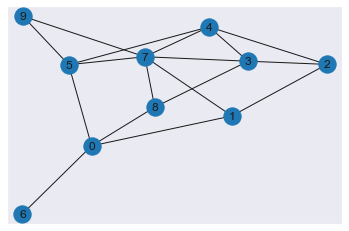

In [22]:
from p2psimpy.config import *
from p2psimpy.consts import *
import networkx as nx

class Locations(Config):
    locations = ['LocA', 'LocB']
    latencies = {
        'LocB': {'LocB': Dist('gamma', (1, 1, 1))},
        'LocA': {'LocB': Dist('norm', (12, 2)), 'LocA': Dist('norm', (2, 0.5))},
    } 

# Number of nodes
N = 10
    
# Generate network topology 
G = nx.erdos_renyi_graph(N, 0.5)
# Assign a peer type to the peers 
nx.set_node_attributes(G, {k: 'basic' for k in G.nodes()}, 'type')

class PeerConfig(Config):
    location = Dist('sample', Locations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Let's add ConnectionManager - that will periodically ping neighbours and check if they are online 
from p2psimpy.services.connection_manager import BaseConnectionManager
# For each service you can define own configuration, or use default values.   
# Lets use base connection manager - that will periodically ping peer and disconnect unresponsive peers.

services = (BaseConnectionManager,)
peer_types = {'basic': PeerType(PeerConfig, services)}

# Display the topology 
nx.draw_networkx(G)

In [23]:
from p2psimpy.simulation import BaseSimulation

# Create BaseSimulation with enabled logger and save in the logs directory. 
sim = BaseSimulation(Locations, G, peer_types, enable_logger=True, logger_dir='logs')

# Let's run the simulation for 5 seconds
sim.run(5_000)

----------------------------

What's next? There is no output.

We run the simulator with logger enabled to see the all the messages exchanged in the network. 

The output is written to the logs in `\logs` directory. Let's see what is the output. 
Each peer writes own log with events happening like received message, connecting to a peer etc. 

For example, here is the log of peer 1:

In [24]:
with open('logs/Peer_1:basic.log') as s:
    print(s.read())

Peer_1:basic INFO 0.7723595936792576: Connecting to Peer_2:basic
Peer_1:basic INFO 0.9363359348954996: Received message <Hello:> from Peer_2:basic
Peer_1:basic INFO 1.5706911106510957: Received message <Hello:> from Peer_2:basic
Peer_1:basic INFO 4.103608846885771: Received message <Hello:> from Peer_7:basic
Peer_1:basic INFO 4.103608846885771: Connecting to Peer_7:basic
Peer_1:basic INFO 4.103608846885771: Sending message <Hello:> to Peer_7:basic
Peer_1:basic INFO 4.93753036716547: Connecting to Peer_2:basic
Peer_1:basic INFO 5.964424376096276: Received message <Hello:> from Peer_2:basic
Peer_1:basic INFO 11.145142614852492: Received message <Hello:> from Peer_2:basic
Peer_1:basic INFO 1000: Sending message <Ping:> to Peer_2:basic
Peer_1:basic INFO 1000: Sending message <Ping:> to Peer_7:basic
Peer_1:basic INFO 1000: Sending message <Ping:> to Peer_2:basic
Peer_1:basic INFO 1000.6095521451093: Received message <Ping:> from Peer_2:basic
Peer_1:basic INFO 1000.6095521451093: Sending mes

## Emergent topology

Now let's try an emergent topology, we will use the same configuration, but use bootstrap peer for discovery and building a network. For the connection manager we will use `P2PConnectionManager`.  


In [25]:
from p2psimpy.services.connection_manager import P2PConnectionManager

num_peers = 10

topology_specs = {i:{'type': 'basic'} for i in range(1, num_peers+1)}

class ConnectionConfig(Config):
    min_peers = 4
    max_peers = 8

peer_types = {'basic': PeerType(PeerConfig, {P2PConnectionManager: ConnectionConfig})}


In [26]:
sim = BaseSimulation(Locations, topology_specs, peer_types, logger_dir='logs2')

# Let's run the simulation for 5 seconds
sim.run(5_000)

#### The peers form themselves a random topology

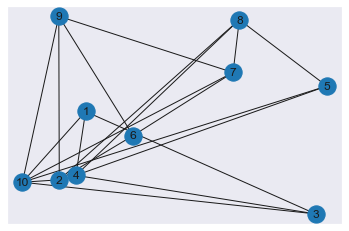

In [27]:
G1 = sim.get_graph()
nx.draw_networkx(G1)

In [28]:
with open('logs2/Peer_1:basic.log') as s:
    print(s.read())

Peer_1:basic WARNING 0: Not enough peers, fetching more (0, 4)
Peer_1:basic INFO 0.565874236628629: Connecting to Peer_11:bootstrap
Peer_1:basic INFO 1.461062035334456: Received message <Hello:> from Peer_11:bootstrap
Peer_1:basic INFO 2.7488533401304944: Received message <RequestPeers:> from Peer_11:bootstrap
Peer_1:basic INFO 2.7488533401304944: Sending message <PeerList> to Peer_11:bootstrap
Peer_1:basic WARNING 500: Not enough peers, fetching more (1, 4)
Peer_1:basic INFO 500: Sending message <RequestPeers:> to Peer_11:bootstrap
Peer_1:basic INFO 501.6394384211931: Received message <PeerList> from Peer_11:bootstrap
Peer_1:basic WARNING 1000: Not enough peers, fetching more (1, 4)
Peer_1:basic INFO 1000: Sending message <RequestPeers:> to Peer_11:bootstrap
Peer_1:basic INFO 1000.6862906340558: Received message <RequestPeers:> from Peer_11:bootstrap
Peer_1:basic INFO 1000.6862906340558: Sending message <PeerList> to Peer_11:bootstrap
Peer_1:basic INFO 1000.7676327188423: Connecting t

------------------

Now you get how to work a simulation, in the next notebook we will take a look into services and implement our own.  


## Your experiments here 


1. Change the latency between the locations and look at the logs.  
2. Change the rules for the discovery

